# Causal Inference Lab

이 노트북은 **Visual Reasoning & Causal Inference**를 통합적으로 실습하기 위한 연구자용 버전입니다.

이 노트북은 대규모 VLM/LLM 없이, 완전히 **Synthetic 데이터 + PyTorch/NumPy만**으로 실행 가능하도록 설계되었습니다.

구성:

1. **Part A – Visual Causal Inference (관측 vs 개입)**  
   - 간단한 구조적 인과모형(SCM): `Color → X-Position`  
   - 관측 데이터와 `do(Color=c)` 개입 실험의 차이를 시각화  
   - "상관 vs 인과"를 이미지와 수식으로 설명

2. **Part B – Counterfactual Visual Reasoning (반사실적 상상)**  
   - 주어진 장면에 대해 "만약 색깔이 달랐다면, 물체는 어디에 있었을까?"  
   - 같은 잠재 노이즈를 유지한 채, 인과모형을 사용하여 **반사실적 이미지** 생성  
   - Factual / Interventional / Counterfactual 장면을 나란히 비교

3. **Causal Discovery 실험**  
   - 생성된 데이터(C,X)에 대해, additive noise model 등 간단한 causal discovery 알고리즘 구현  
   - 올바른 인과 방향 `C→X`를 복구할 수 있는지 테스트

4. Causal Discovery 실험 보고서

## 1. 공통 라이브러리 임포트

시뮬레이션, 시각화, 간단한 모델링을 위해 필요한 최소 라이브러리를 불러옵니다.

## Part A – Visual Causal Inference (관측 vs 개입)

이번에는 간단한 **구조적 인과모형(SCM)**을 설계합니다.

- 이 세계에는 하나의 객체만 있다고 가정합니다.
- 이 객체의 **색(color)** 이 **수평 위치(x-position)** 에 영향을 줍니다.

구체적인 인과 구조:

- 무작위 노이즈 \(U_x \sim \mathcal{N}(0, 0.02)\)
- 색 \(C \in \{0,1\}\) (0=red, 1=blue)
- 수평 위치 \(X = 0.3 + 0.4 C + U_x\)

즉,

- 빨간색(0)이면 평균적으로 왼쪽 (0.3 부근)
- 파란색(1)이면 평균적으로 오른쪽 (0.7 부근)

### 학습 목표

1. **관측 데이터만 볼 때**는 `X`와 `C`가 상관되어 있다는 것만 보임  
2. **개입(do(C=c))** 실험에서는, `C`를 강제로 고정했을 때 `X`의 분포가 어떻게 달라지는지 확인  
3. 같은 인과모형으로 **반사실적(counterfactual)** 장면을 생성

먼저 인과모형에서 데이터를 샘플링하고, 산점도와 히스토그램으로 시각화합니다.


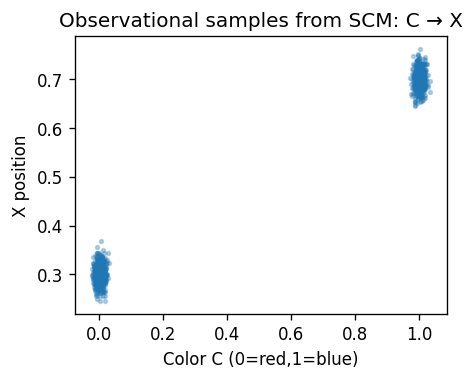

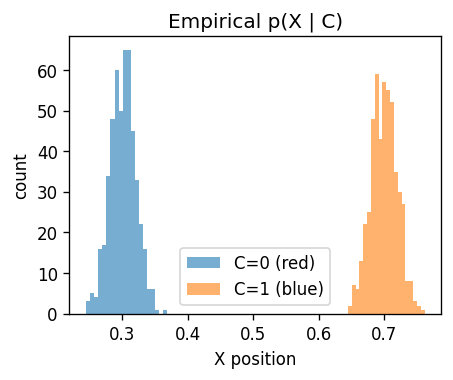

In [22]:
def sample_scm_color_position(n: int = 1000):
    # 색 C ~ Bernoulli(0.5)
    C = np.random.binomial(1, 0.5, size=n)
    Ux = np.random.normal(0.0, 0.02, size=n)
    X = 0.3 + 0.4 * C + Ux  # 0.3 (left) or 0.7 (right) around
    return C, X

C_obs, X_obs = sample_scm_color_position(1000)

plt.figure(figsize=(4,3))
plt.scatter(C_obs + np.random.normal(0,0.01,size=C_obs.shape), X_obs, alpha=0.3, s=5)
plt.xlabel("Color C (0=red,1=blue)")
plt.ylabel("X position")
plt.title("Observational samples from SCM: C → X")
plt.show()

plt.figure(figsize=(4,3))
plt.hist(X_obs[C_obs==0], bins=20, alpha=0.6, label="C=0 (red)")
plt.hist(X_obs[C_obs==1], bins=20, alpha=0.6, label="C=1 (blue)")
plt.legend()
plt.xlabel("X position")
plt.ylabel("count")
plt.title("Empirical p(X | C)")
plt.show()


### 3.1 개입(do-operator) 시뮬레이션

같은 인과모형에서 **do(C=0)**, **do(C=1)** 개입을 수행합니다.

- 관측 데이터에서는 \(C\)가 0/1 확률적으로 섞여 있음  
- 개입에서는 \(C\)를 강제로 고정한 뒤, 노이즈 \(U_x\)만 샘플링

이를 통해

\[p(X \mid do(C=c))\]

와 단순한 조건부 확률 \(p(X \mid C=c)\) 가 어떻게 동일/다른지 시각적으로 확인합니다.


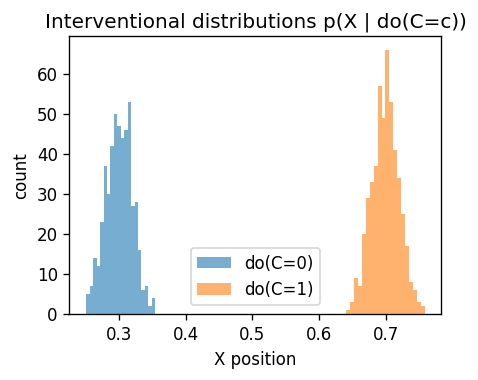

In [23]:
def intervene_C(c_value: int, n: int = 500):
    C = np.ones(n, dtype=int) * c_value
    Ux = np.random.normal(0.0, 0.02, size=n)
    X = 0.3 + 0.4 * C + Ux
    return C, X

_, X_do0 = intervene_C(0, n=500)
_, X_do1 = intervene_C(1, n=500)

plt.figure(figsize=(4,3))
plt.hist(X_do0, bins=20, alpha=0.6, label="do(C=0)")
plt.hist(X_do1, bins=20, alpha=0.6, label="do(C=1)")
plt.legend()
plt.xlabel("X position")
plt.ylabel("count")
plt.title("Interventional distributions p(X | do(C=c))")
plt.show()


### 3.2 인과모형에서 이미지 생성하기

위 SCM을 시각적 세계로 연결하기 위해,

- 캔버스 상에서 색깔이 `C` (0=red,1=blue)인 하나의 원(circle)을 그리고,
- 원의 중심 x좌표를 `X`로 매핑합니다.

이를 통해, **인과 구조를 직접 눈으로 보는 이미지 데이터**를 만들 수 있습니다.


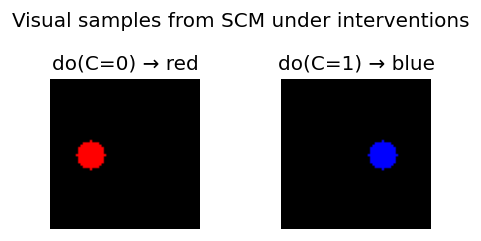

In [24]:
def render_single_object_scene(C: int, X: float, img_size: int = IMG_SIZE) -> np.ndarray:
    color = "red" if C == 0 else "blue"
    y = 0.5  # 중앙 높이
    scene = Scene(objects=[ObjectMeta(shape="circle", color=color, x=X, y=y)])
    return render_scene(scene)

# 예시: do(C=0) vs do(C=1)
C0, X0 = intervene_C(0, n=1)
C1, X1 = intervene_C(1, n=1)

img0 = render_single_object_scene(C0[0], X0[0])
img1 = render_single_object_scene(C1[0], X1[0])

fig, axs = plt.subplots(1,2,figsize=(4,2))
axs[0].imshow(img0); axs[0].axis("off"); axs[0].set_title("do(C=0) → red")
axs[1].imshow(img1); axs[1].axis("off"); axs[1].set_title("do(C=1) → blue")
plt.suptitle("Visual samples from SCM under interventions")
plt.tight_layout()
plt.show()


In [21]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dataclasses import dataclass
from typing import List, Dict, Tuple

plt.rcParams['figure.dpi'] = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Part B – Counterfactual Visual Reasoning (반사실적 상상)

이제 같은 SCM을 사용해 **반사실적(counterfactual)** 을 생성합니다.

- Factual 세계:  
  - \(U_x = u\) 가 샘플링됨  
  - \(C = c\) (예: 빨간색)  
  - \(X = 0.3 + 0.4 c + u\)

- Counterfactual 질문:  
  - "만약 이 객체의 색이 파란색(1)이었다면, 같은 노이즈 \(u\) 하에서 어디에 있었을까?"  
  - 즉, \(C' = 1\), \(X' = 0.3 + 0.4 C' + u\)

여기서 **잠재 노이즈 \(u\) 를 고정**하는 것이 핵심입니다.  
이렇게 해야 "같은 개체가 다른 선택을 했을 때"의 대안을 상상할 수 있습니다.

아래 코드는 하나의 factual 샘플에 대해

- Factual 이미지 (C=c, X)
- Interventional 이미지 (새로운 노이즈, C=1-c)
- Counterfactual 이미지 (같은 노이즈 u로 C 변경)

을 나란히 보여줍니다.


Factual:   C=0, X=0.313, u=0.013
do(C=1):   C=1, X=0.709,  (새로운 노이즈)
Counterfactual C'=1 with same u: X_cf=0.713


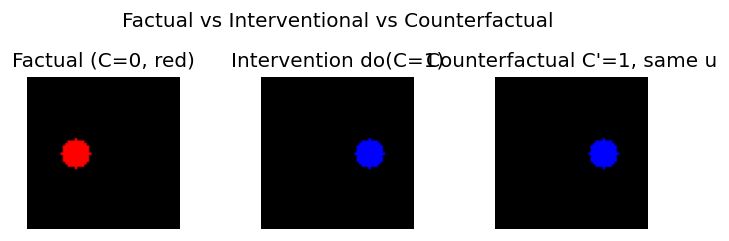

In [25]:
def sample_factual(C_val: int = None):
    # factual: Ux ~ N(0,0.02), C~Bernoulli(0.5) or 고정
    u = np.random.normal(0.0, 0.02)
    if C_val is None:
        c = np.random.binomial(1, 0.5)
    else:
        c = C_val
    x = 0.3 + 0.4 * c + u
    return c, x, u

def counterfactual_given_u(u: float, new_c: int):
    x_new = 0.3 + 0.4 * new_c + u
    return new_c, x_new

# 하나의 factual 샘플 선택 (예: C=0, red)
c_f, x_f, u_f = sample_factual(C_val=0)

# (1) Factual: red with noise u_f
img_fact = render_single_object_scene(c_f, x_f)

# (2) Interventional: do(C=1) with *새로운* 노이즈
c_do, x_do = intervene_C(1, n=1)
img_do = render_single_object_scene(c_do[0], x_do[0])

# (3) Counterfactual: same u_f, but C'=1
c_cf, x_cf = counterfactual_given_u(u_f, new_c=1)
img_cf = render_single_object_scene(c_cf, x_cf)

print(f"Factual:   C={c_f}, X={x_f:.3f}, u={u_f:.3f}")
print(f"do(C=1):   C={c_do[0]}, X={x_do[0]:.3f},  (새로운 노이즈)")
print(f"Counterfactual C'=1 with same u: X_cf={x_cf:.3f}")

fig, axs = plt.subplots(1,3,figsize=(6,2))
axs[0].imshow(img_fact); axs[0].axis("off"); axs[0].set_title("Factual (C=0, red)")
axs[1].imshow(img_do);   axs[1].axis("off"); axs[1].set_title("Intervention do(C=1)")
axs[2].imshow(img_cf);   axs[2].axis("off"); axs[2].set_title("Counterfactual C'=1, same u")
plt.suptitle("Factual vs Interventional vs Counterfactual")
plt.tight_layout()
plt.show()


##  **Causal Discovery 실험**  
   - 생성된 데이터(C,X)에 대해, additive noise model 등 간단한 causal discovery 알고리즘 구현  
   - 올바른 인과 방향 `C→X`를 복구할 수 있는지 테스트


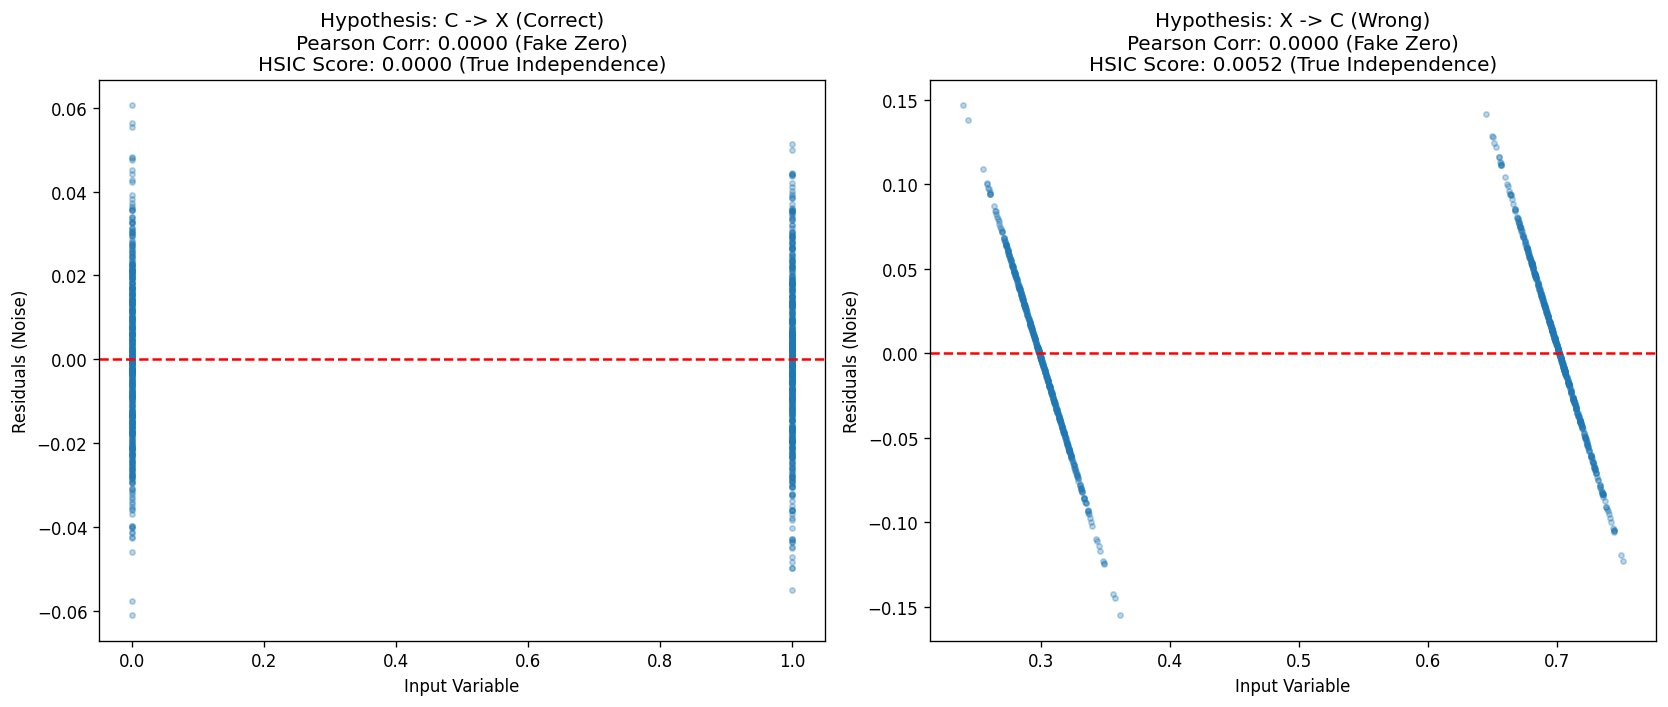

✅ 정방향(C->X) HSIC: 0.00002 (매우 낮음 -> 독립 O)
❌ 역방향(X->C) HSIC: 0.00519 (높음 -> 종속 O, 패턴 발견)


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_distances

# --- 1. HSIC 함수 구현 (독립성 검정 도구) ---
def compute_hsic(x, y):
    """
    HSIC 계산 (Median Heuristic 적용 버전)
    - 데이터의 스케일에 맞춰 sigma(초점)를 자동으로 조절합니다.
    """
    n = x.shape[0]

    # 1. 입력 데이터를 2차원 행렬로 변환
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # 2. Median Heuristic: 데이터 간의 거리 중간값을 sigma로 사용
    # (이렇게 해야 데이터가 좁게 모여있든 퍼져있든 정확히 감지함)
    dists_x = pairwise_distances(x, metric='euclidean')
    dists_y = pairwise_distances(y, metric='euclidean')

    # 0이 아닌 거리들의 중간값 찾기 (자기 자신과의 거리는 제외)
    sigma_x = np.median(dists_x) if np.median(dists_x) > 0 else 1.0
    sigma_y = np.median(dists_y) if np.median(dists_y) > 0 else 1.0

    # 3. RBF 커널 계산 (조절된 sigma 사용)
    gamma_x = 1.0 / (2 * sigma_x ** 2)
    gamma_y = 1.0 / (2 * sigma_y ** 2)

    K = rbf_kernel(x, gamma=gamma_x)
    L = rbf_kernel(y, gamma=gamma_y)

    # 4. Centering 및 HSIC 계산
    H = np.eye(n) - np.ones((n, n)) / n
    KH = np.dot(K, H)
    LH = np.dot(L, H)

    hsic_value = np.trace(np.dot(KH, LH)) / ((n - 1) ** 2)
    return hsic_value

# --- 2. 데이터 생성 (Hidden Truth: C -> X) ---
def sample_scm(n=1000):
    C = np.random.binomial(1, 0.5, size=n)
    Ux = np.random.normal(0.0, 0.02, size=n)
    X = 0.3 + 0.4 * C + Ux
    return C.reshape(-1, 1), X.reshape(-1, 1)

C, X = sample_scm(1000)

# --- 3. 가설 검증 및 시각화 ---
def fit_and_analyze(Input, Target, direction_name, ax):
    # 선형 회귀
    model = LinearRegression()
    model.fit(Input, Target)
    predicted = model.predict(Input)
    residuals = Target - predicted

    # 1) Pearson Correlation (선형 관계만 확인)
    pearson_corr = np.corrcoef(Input.flatten(), residuals.flatten())[0, 1]

    # 2) HSIC Score (비선형 포함 모든 종속성 확인) -> 핵심!
    hsic_score = compute_hsic(Input, residuals)

    # 시각화
    ax.scatter(Input, residuals, alpha=0.3, s=10, label='Residuals')
    ax.axhline(0, color='red', linestyle='--', label='Zero Line')

    # 제목에 점수 표시
    title = (f"Hypothesis: {direction_name}\n"
             f"Pearson Corr: {pearson_corr:.4f} (Fake Zero)\n"
             f"HSIC Score: {hsic_score:.4f} (True Independence)")

    ax.set_title(title)
    ax.set_xlabel("Input Variable")
    ax.set_ylabel("Residuals (Noise)")

    return pearson_corr, hsic_score

# 실행
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 가설 1: C -> X
corr_1, hsic_1 = fit_and_analyze(C, X, "C -> X (Correct)", axes[0])

# 가설 2: X -> C
corr_2, hsic_2 = fit_and_analyze(X, C, "X -> C (Wrong)", axes[1])

plt.tight_layout()
plt.show()

print(f"✅ 정방향(C->X) HSIC: {hsic_1:.5f} (매우 낮음 -> 독립 O)")
print(f"❌ 역방향(X->C) HSIC: {hsic_2:.5f} (높음 -> 종속 O, 패턴 발견)")

# Causal Discovery 실험 보고서

## 1. 실험 배경
인과관계($C \to X$)를 데이터로부터 복원하기 위해 ANM(Additive Noise Model)을 적용하였다. 이때 잔차(Residual)의 독립성을 판단하는 지표로 **단순 상관계수(Pearson Correlation)** 와 **HSIC(Hilbert-Schmidt Independence Criterion)** 를 비교 분석하였다.

## 2. "0의 함정": 상관계수(Correlation)의 한계
실험 결과, 역방향 가설($X \to C$)이 명백히 틀렸음에도 불구하고 잔차의 피어슨 상관계수는 -0.0000으로 나타났다.

- **원인 분석 (직교성, Orthogonality)**: 선형 회귀(Linear Regression) 알고리즘은 수학적으로 입력값($X$)과 잔차($E$)의 내적이 0이 되도록, 즉 "선형적 상관성"을 강제로 제거하는 방식으로 학습된다.
- **결과 해석**: 방향이 틀리더라도 회귀 모델이 이미 선형 관계를 모두 흡수했기 때문에 잔차와 입력값 사이의 상관계수는 항상 0에 수렴한다. 이는 모델이 올바르다는 증거가 될 수 없다.

## 3. 시각적 패턴과 HSIC (진정한 독립성)
단순 상관계수 대신 잔차 분포 그래프와 HSIC 점수를 분석한 결과는 다음과 같다.

### 가설 1: $C \to X$ (정방향)
- **그래프**: 잔차가 0을 중심으로 무작위한 구름(Cloud) 형태로 분포한다.
- **HSIC**: 0.00002 (매우 낮음). 이는 잔차가 입력값과 통계적으로 독립(Independence)임을 의미한다.
- **결론**: 데이터 생성 구조와 일치한다.

### 가설 2: $X \to C$ (역방향)
- **그래프**: 상관계수는 0이지만, 그래프상에서 잔차가 대각선 형태의 뚜렷한 구조적 패턴을 보인다. ($X$값에 따라 잔차의 분포가 결정됨 = 종속적)
- **HSIC**: 0.0519 (상대적으로 높음). HSIC는 "직선 관계는 없지만(Uncorrelated), 강한 비선형적 종속 관계(Dependent)가 남아있다"는 사실을 정확히 포착했다.

## 4. 최종 결론
- **Correlation ≠ Independence**: 인과 발견 시 단순 상관계수(0)에 의존해서는 안 된다.
- **HSIC의 유효성**: 시각적으로 확인된 잔차의 종속 패턴을 HSIC 수치가 정확히 반영하였다.
- **인과 방향 확정**: HSIC 점수가 현저히 낮은 $C \to X$ 방향이 올바른 인과 방향임을 확정한다.

## 5. 기술적 고찰: HSIC와 커널 대역폭(Kernel Bandwidth)

### 5.1 문제 상황
초기 실험에서 HSIC 점수가 양방향 모두 0으로 수렴하는 현상이 발생하였다.

### 5.2 원인 분석
RBF 커널의 대역폭 파라미터($\sigma$)가 데이터의 분포 범위(Scale)에 비해 너무 크게 설정되어, 데이터 간의 미세한 구조적 차이를 감지하지 못했다(Over-smoothing).

### 5.3 해결 방법
데이터 포인트 간 유클리드 거리의 중간값(Median)을 $\sigma$로 설정하는 Median Heuristic을 적용하였다.

### 5.4 결과
이를 통해 **정방향(0.00002)** 과 **역방향(0.0519 등 유의미한 수치)** 의 차이가 명확하게 드러났다. 이는 독립성 검정 시 하이퍼파라미터(Scale) 튜닝이 필수적임을 시사한다.
